# House price regression

## Description of the notebook

This notebook is organized in 7 parts.

1. Data acquisition: we will import the dataset and get a first glance at what it contains.

2. Dataset exploratory analysis : we will analyze the data, get an understanding of the main features, of their types, if they have missing values...

3. Features exploratory analysis : we will analyze the data,find the corelation between the features and the survival rate and decide which features to keep

4. Data cleaning and feature selection : Select features that will be kept in the model and remove others, deal with missing values if there is any, create dummy variables for categories...

5. Model preparation : prepare the train and test set and prepare the models we will use for the classification

6. Pipeline evaluation and selection: We will run the models and get their scores, which will allow us the choose the best model.

7. Predict : Final stage, we will run our final model to execute predictions.

# 1. Data acquisition

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import r2_score, max_error, mean_absolute_error, mean_squared_error, mean_squared_log_error

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import FunctionTransformer

from sklearn.decomposition import PCA

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

from sklearn.ensemble import VotingClassifier

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

sns.set_style('darkgrid')
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
dataset_train = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')
dataset_test = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')

# 2. Dataset Exploratory analysis
In this section we will check the number and types of features for the dataset, if there is missing values, if there is corelation between some features, if we can remove some unnecessary features and if we can create new features from the ones we already have

In [3]:
def screen_data(df):
    rows = []
    for col in df.columns:
        rows.append([col, df[col].isnull().sum(), df[col].nunique(), df[col].dtypes])
    return pd.DataFrame(rows, columns=['Col', 'Missing values', 'Unique values', 'Type'])

In [4]:
def screen_missing_values(df, ratio=0.1, verbose=0):
    total_rows = len(df)
    total_columns = len(df.columns)
    df = screen_data(df)
    df_m = df.loc[df['Missing values'] != 0]#.sort_values(['Type', 'Missing values'])
    total_missing_values = len(df_m)
    df_m.loc[:, 'Percentage missing values'] = df_m['Missing values']/total_rows
    missing_values_less10 = len(df_m.loc[df_m['Percentage missing values'] <= ratio])
    missing_values_more10 = len(df_m.loc[df_m['Percentage missing values'] > ratio])
    print('Total missing values : ',total_missing_values, ' --> ', round(100*total_missing_values/total_columns,0), '% of all features')
    print('Columns with less than ', round(ratio*100,0),'% missing values : ',missing_values_less10, ' --> ', round(100*missing_values_less10/total_missing_values, 0), '% of features with missing values')
    print('Columns with more than ', round(ratio*100,0),'% missing values : ',missing_values_more10, ' --> ', round(100*missing_values_more10/total_missing_values, 0), '% of features with missing values')
    if(verbose >= 1):
        print("")
        print(df_m.drop(columns=['Unique values', 'Type']).loc[df_m['Percentage missing values'] > ratio])

## 2.1 Dataframe information

In [5]:
dataset_train.shape, dataset_test.shape

((1460, 81), (1459, 80))

The train and the test set are the same size, so it's going to be important not to overfit the model.

In [6]:
dataset_train.head(10)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
5,6,50,RL,85.0,14115,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1.5Fin,5,5,1993,1995,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,Wood,Gd,TA,No,GLQ,732,Unf,0,64,796,GasA,Ex,Y,SBrkr,796,566,0,1362,1,0,1,1,1,1,TA,5,Typ,0,NaN,Attchd,1993.0,Unf,2,480,TA,TA,Y,40,30,0,320,0,0,NaN,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,7,20,RL,75.0,10084,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,1Fam,1Story,8,5,2004,2005,Gable,CompShg,VinylSd,VinylSd,Stone,186.0,Gd,TA,PConc,Ex,TA,Av,GLQ,1369,Unf,0,317,1686,GasA,Ex,Y,SBrkr,1694,0,0,1694,1,0,2,0,3,1,Gd,7,Typ,1,Gd,Attchd,2004.0,RFn,2,636,TA,TA,Y,255,57,0,0,0,0,NaN,NaN,NaN,0,8,2007,WD,Normal,307000
7,8,60,RL,NaN,10382,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NWAmes,PosN,Norm,1Fam,2Story,7,6,1973,1973,Gable,CompShg,HdBoard,HdBoard,Stone,240.0,TA,TA,CBlock,Gd,TA,Mn,ALQ,859,BLQ,32,216,1107,GasA,Ex,Y,SBrkr,1107,983,0,2090,1,0,2,1,3,1,TA,7,Typ,2,TA,Attchd,1973.0,RFn,2,484,TA,TA,Y,235,204,228,0,0,0,NaN,NaN,Shed,350,11,2009,WD,Normal,200000
8,9,50,RM,51.0,6120,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Artery,Norm,1Fam,1.5Fin,7,5,1931,1950,Gable,CompShg,BrkFace,Wd Shng,None,0.0,TA,TA,BrkTil,TA,TA,No,Unf,0,Unf,0,952,952,GasA,Gd,Y,FuseF,1022,752,0,1774,0,0,2,0,2,2,TA,8,Min1,2,TA,Detchd,1931.0,Unf,2,468,Fa,TA,Y,90,0,205,0,0,0,NaN,NaN,NaN,0,4,2008,WD,Abnorml,129900
9,10,190,RL,50.0,7420,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,BrkSide,Artery,Artery,2fmCon,1.5Unf,5,6,1939,1950,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,BrkTil,TA,TA,No,GLQ,851,Unf,0,140,991,Gas

In [7]:
df = screen_data(dataset_train)
df.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80
Col,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Missing values,0,0,0,259,0,0,1369,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8,8,0,0,0,37,37,38,37,0,38,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,690,81,81,81,0,0,81,81,0,0,0,0,0,0,0,1453,1179,1406,0,0,0,0,0,0
Unique values,1460,15,5,110,1073,2,2,4,4,2,5,3,25,9,8,5,8,10,9,112,61,6,8,15,16,4,327,4,5,6,4,4,4,6,637,6,144,780,721,6,5,2,5,753,417,24,861,4,3,4,3,8,4,4,12,7,4,5,6,97,3,5,441,5,5,3,274,202,120,20,76,8,3,4,4,21,12,5,9,6,663
Type,int64,int64,object,float64,int64,object,object,object,object,object,object,object,object,object,object,object,object,int64,int64,int64,int64,object,object,object,object,object,float64,object,object,object,object,object,object,object,int64,object,int64,int64,int64,object,object,object,object,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,object,int64,object,int64,object,object,float64,object,int64,int64,object,object,object,int64,int64,int64,int64,int64,int64,object,object,object,int64,int64,int64,object,object,int64


### Missing values

In [8]:
screen_missing_values(dataset_train, verbose=1)

Total missing values :  19  -->  23.0 % of all features
Columns with less than  10.0 % missing values :  13  -->  68.0 % of features with missing values
Columns with more than  10.0 % missing values :  6  -->  32.0 % of features with missing values

            Col  Missing values  Percentage missing values
3   LotFrontage             259                   0.177397
6         Alley            1369                   0.937671
57  FireplaceQu             690                   0.472603
72       PoolQC            1453                   0.995205
73        Fence            1179                   0.807534
74  MiscFeature            1406                   0.963014


In [9]:
screen_missing_values(dataset_test, verbose=1)

Total missing values :  33  -->  41.0 % of all features
Columns with less than  10.0 % missing values :  27  -->  82.0 % of features with missing values
Columns with more than  10.0 % missing values :  6  -->  18.0 % of features with missing values

            Col  Missing values  Percentage missing values
3   LotFrontage             227                   0.155586
6         Alley            1352                   0.926662
57  FireplaceQu             730                   0.500343
72       PoolQC            1456                   0.997944
73        Fence            1169                   0.801234
74  MiscFeature            1408                   0.965045


In the dataset test there is more columns with missing values, but most of them have less than 10% missing values. <br>
The column with more than 10% missing values are the same in train and test. <br>
The columns might have missing values to indicate an absence of pool or fireplace for example, we will have to analyse things a bit more to conclude.

### Types of data

In [10]:
print('Categorical features : ', len(dataset_train.drop(columns=['Id', 'SalePrice']).select_dtypes(include='object').columns))
print('Numerical features : ', len(dataset_train.drop(columns=['Id', 'SalePrice']).select_dtypes(exclude='object').columns))
print('Total features : ', len(dataset_train.drop(columns=['Id', 'SalePrice']).columns))

Categorical features :  43
Numerical features :  36
Total features :  79


A lot of numerical and categorical data

## 2.2 Data description

Based on this very small analysis we can see that we have 79 different features. <br>
In order to start analysing we will have to choose some feature we think might give us a good aproximation of the sale price. <br>
It is not possible to carry an extensive EDA on all the features. <br>
Let's if we can drop some feature which give us the same info (abs(corr) > 0.85), or that represent the same idea.

## Let's check the document describing the data

### Columns we will analyse
- MSZoning because there is probably a difference between an agriculture zone, an industrial zone and a residential zone.
- Lot area, which is the size of the lot
- Neighborhood, probably the price is not the same depending on the neighborhood.
- OverallQual & OverallCond
- YearBuilt & YearRemodAdd
- MoSold, YrSold: maybe the time of year has an impact on the price
- SaleType
- Bedroom & TotRmsAbvGrd
- TotalSF = TotalBsmtSF + 1stFlrSF + 2ndFlrSF

### Columns we will transform
- OverallQual & OverallCond, we can probably aggregate thse columns together
- YearBuilt & YearRemodAdd
- Check if all these columns ExterQual, ExterCond, BsmtCond, BsmtFinType1, BsmtFinType2, HeatingQC, KitchenQual, GarageQual and GarageCond give us a good aproximation of overall quality and overall condition or if there was some errors during the calculation
- TotalSF = TotalBsmtSF + 1stFlrSF + 2ndFlrSF
- TotalBath = FullBath + HalfBath + BsmtFullBath + BsmtHalfBath
- TotalPorch = WoodDeckSF + openPorchSF + EnclosedPorch + 3SsnPorch + ScreenPorch

### Columns we will probably drop
- LandSlope or LandContour, because they contain the same information
- The columns with a lot of missing data, unless they provide very valuable data and we can consider that missing data is just an abscence of pool or fireplace.

# 3. Feature exploratory analysis

Let's start with two categorical data that describe the surroundings of the house MSZoning and Neighborhood.

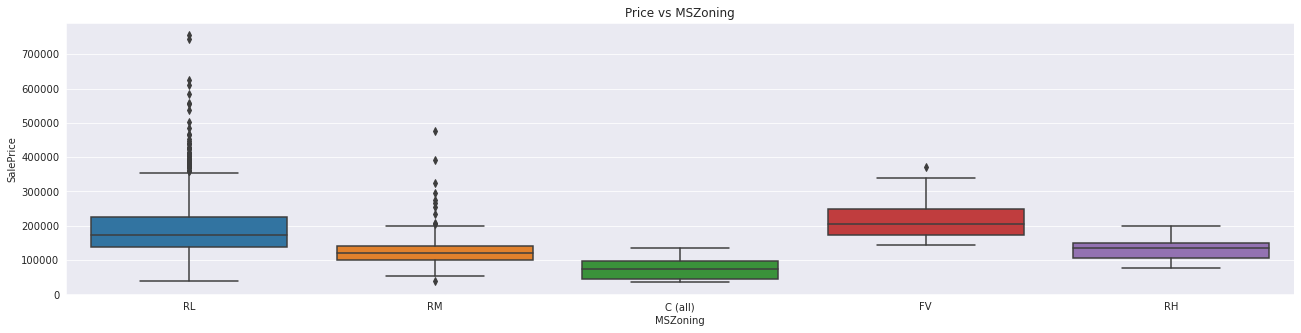

In [11]:
fig, ax = plt.subplots(1,1, figsize=(22,5))
sns.boxplot(x="MSZoning", y="SalePrice", data=dataset_train, ax=ax)
ax.set_title('Price vs MSZoning');

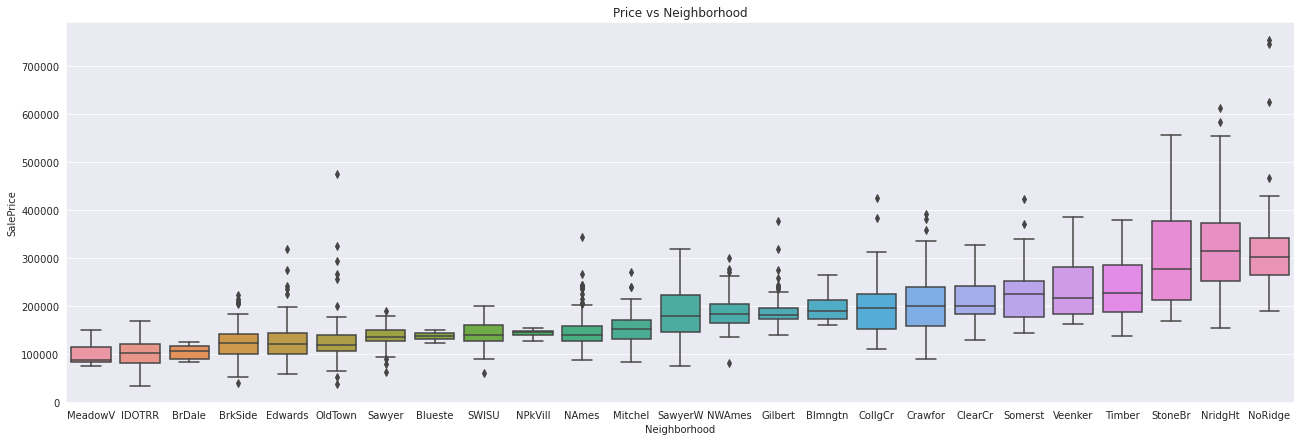

In [12]:
order = dataset_train.groupby('Neighborhood').agg(np.mean).sort_values('SalePrice').index.to_list()
fig, ax = plt.subplots(1,1, figsize=(22,7))
sns.boxplot(x="Neighborhood", y="SalePrice", data=dataset_train, order=order, ax=ax)
ax.set_title('Price vs Neighborhood');

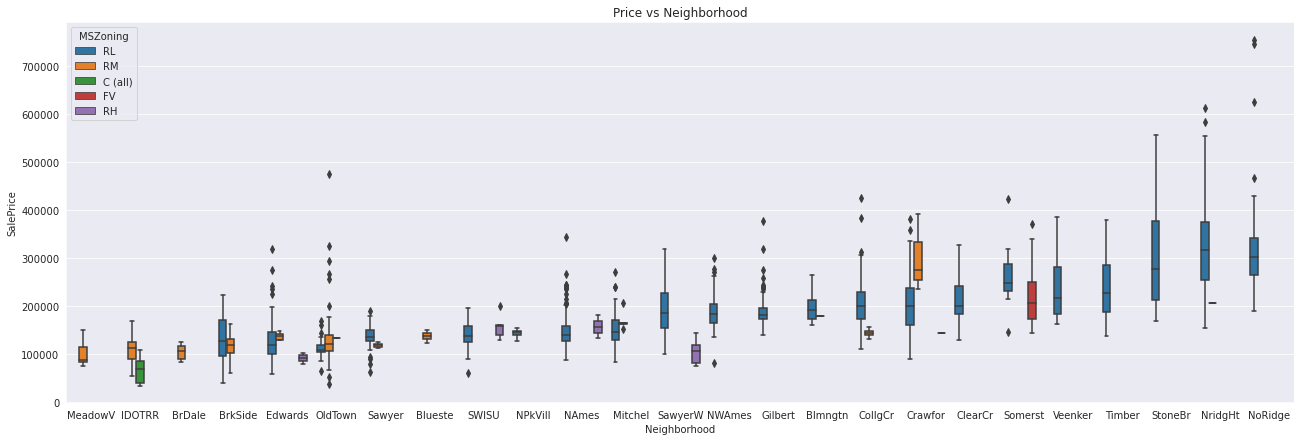

In [13]:
order = dataset_train.groupby('Neighborhood').agg(np.mean).sort_values('SalePrice').index.to_list()
fig, ax = plt.subplots(1,1, figsize=(22,7))
sns.boxplot(x="Neighborhood", y="SalePrice", hue="MSZoning", data=dataset_train, order=order, ax=ax)
ax.set_title('Price vs Neighborhood');

#### Things we can learn from the previous analysis
- The Neighborhood seems to have a big impact on the price
- Inside a neighborhood, the price can change depending on the zone for example in Crawfor.

### Let's continue witht he size of the house
We will check the lot size and the size of the house.

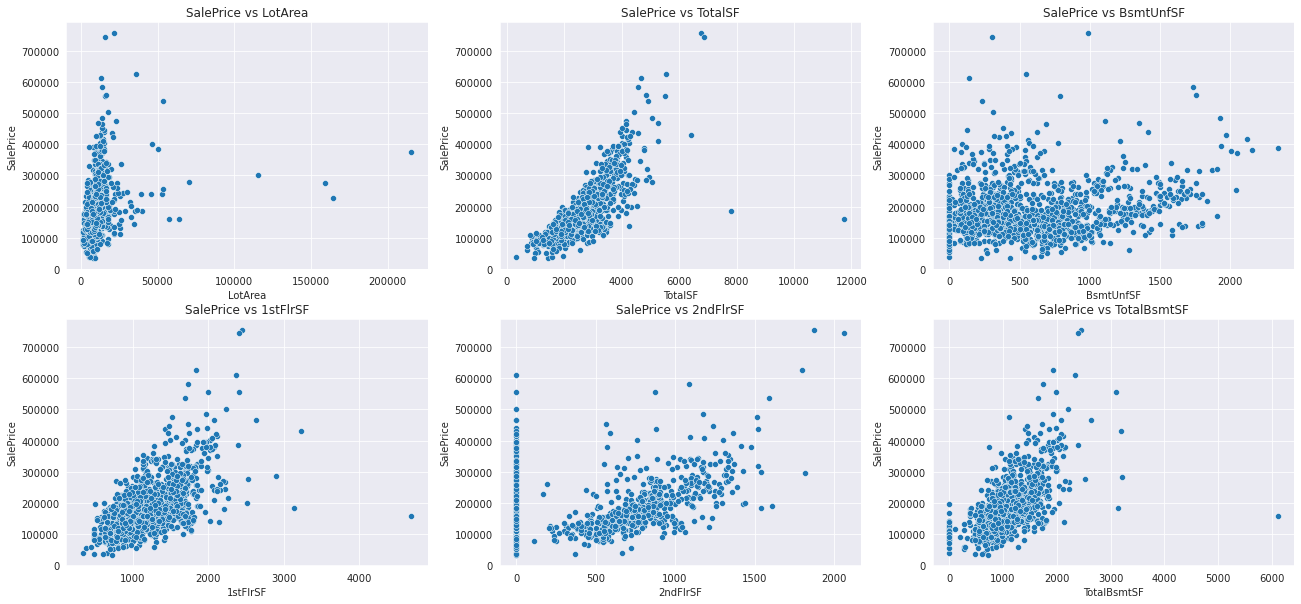

In [35]:
dataset_train['TotalSF'] = dataset_train['1stFlrSF'] + dataset_train['2ndFlrSF'] + dataset_train['TotalBsmtSF']
fig, ax = plt.subplots(2,3, figsize=(22,10))
sns.scatterplot(x="LotArea", y="SalePrice", data=dataset_train, ax=ax[0][0])
ax[0][0].set_title('SalePrice vs LotArea');
sns.scatterplot(x="TotalSF", y="SalePrice", data=dataset_train, ax=ax[0][1])
ax[0][1].set_title('SalePrice vs TotalSF');
sns.scatterplot(x="BsmtUnfSF", y="SalePrice", data=dataset_train, ax=ax[0][2])   # LowQualFinSF or BsmtUnfSF
ax[0][2].set_title('SalePrice vs BsmtUnfSF');
sns.scatterplot(x="1stFlrSF", y="SalePrice", data=dataset_train, ax=ax[1][0])
ax[1][0].set_title('SalePrice vs 1stFlrSF');
sns.scatterplot(x="2ndFlrSF", y="SalePrice", data=dataset_train, ax=ax[1][1])
ax[1][1].set_title('SalePrice vs 2ndFlrSF');
sns.scatterplot(x="TotalBsmtSF", y="SalePrice", data=dataset_train, ax=ax[1][2])
ax[1][2].set_title('SalePrice vs TotalBsmtSF');


#### Things we can learn from the previous analysis
- The lot area is not much correlated to the price, but maybe we can transform this column to get a better correlation (log?)
- The 1stFlrSF, 2ndFlrSF and TotalBsmtSF are correlated to the price but show an increase of the variance when the price increases.
- Summing all these values together give us a better correlation, with some outliers that we might have to remove or transform

### Let's check if the overall quality and condition of the house have an impact on the price

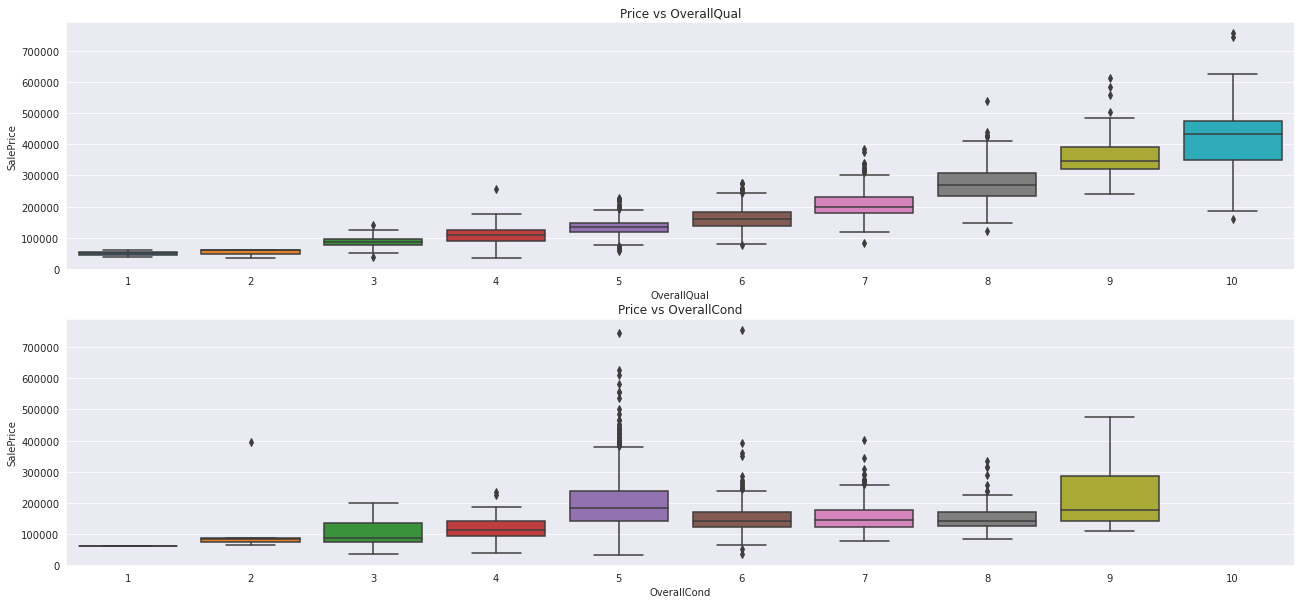

In [15]:
order_qual = dataset_train.groupby('OverallQual').agg(np.mean).sort_values('SalePrice').index.to_list()
order_cond = dataset_train.groupby('OverallCond').agg(np.mean).sort_values('SalePrice').index.to_list()
fig, ax = plt.subplots(2,1, figsize=(22,10))
sns.boxplot(x="OverallQual", y="SalePrice", data=dataset_train, order=order_qual, ax=ax[0])
ax[0].set_title('Price vs OverallQual');
sns.boxplot(x="OverallCond", y="SalePrice", data=dataset_train, order=order_qual, ax=ax[1])
ax[1].set_title('Price vs OverallCond');

#### Things we can learn from the previous analysis
- The overall quality seems a good indicator of the price.
- The overall condition seems less good an indicator of the price, maybe with some binning we could get a better price indicator.

### Let's see what we can learn from the construction year and remodeling year

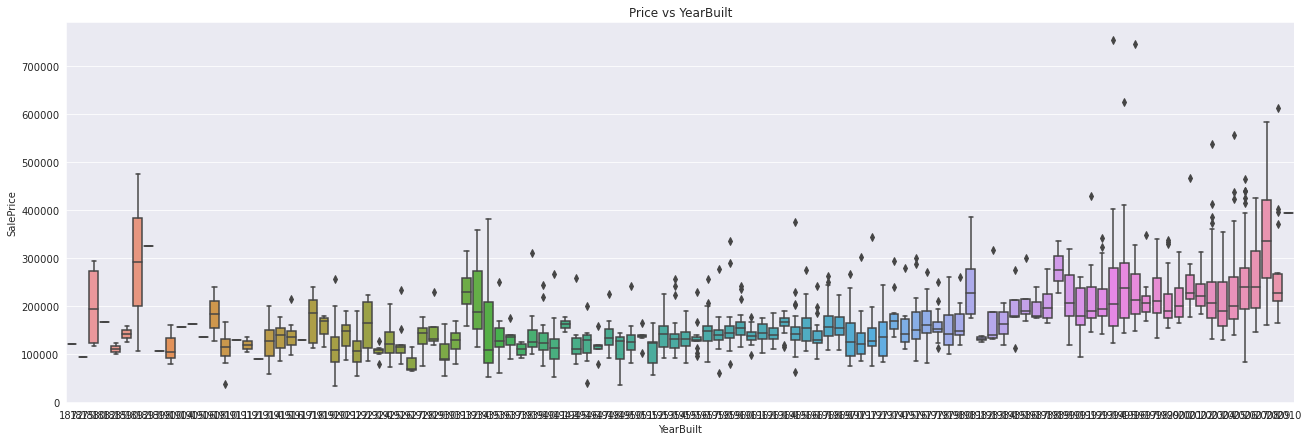

In [16]:
#order = dataset_train.groupby('Neighborhood').agg(np.mean).sort_values('SalePrice').index.to_list()
fig, ax = plt.subplots(1,1, figsize=(22,7))
sns.boxplot(x="YearBuilt", y="SalePrice", data=dataset_train, ax=ax)
ax.set_title('Price vs YearBuilt');

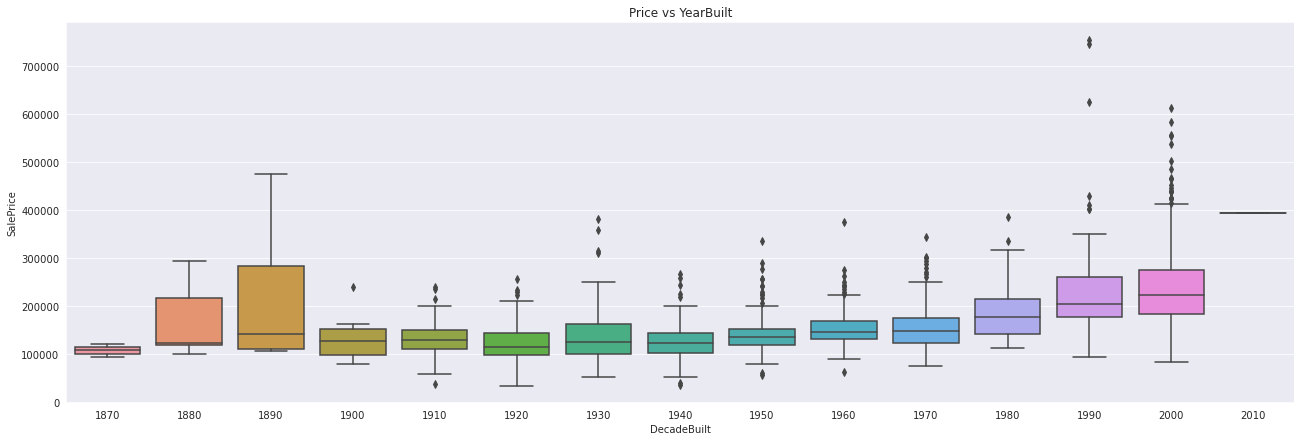

In [17]:
dataset_train['DecadeBuilt'] = dataset_train['YearBuilt']/10
dataset_train['DecadeBuilt'] = dataset_train['DecadeBuilt'].astype(int)*10
#dataset_train[['YearBuilt', 'DecadeBuilt']]

fig, ax = plt.subplots(1,1, figsize=(22,7))
sns.boxplot(x="DecadeBuilt", y="SalePrice", data=dataset_train, ax=ax)
ax.set_title('Price vs YearBuilt');

#### Things we can learn from the previous analysis
- The price of recent houses is a bit higher than houses between 1900 and 1970.
- House in the 1880's and the 1890's are also a bit more expensive.

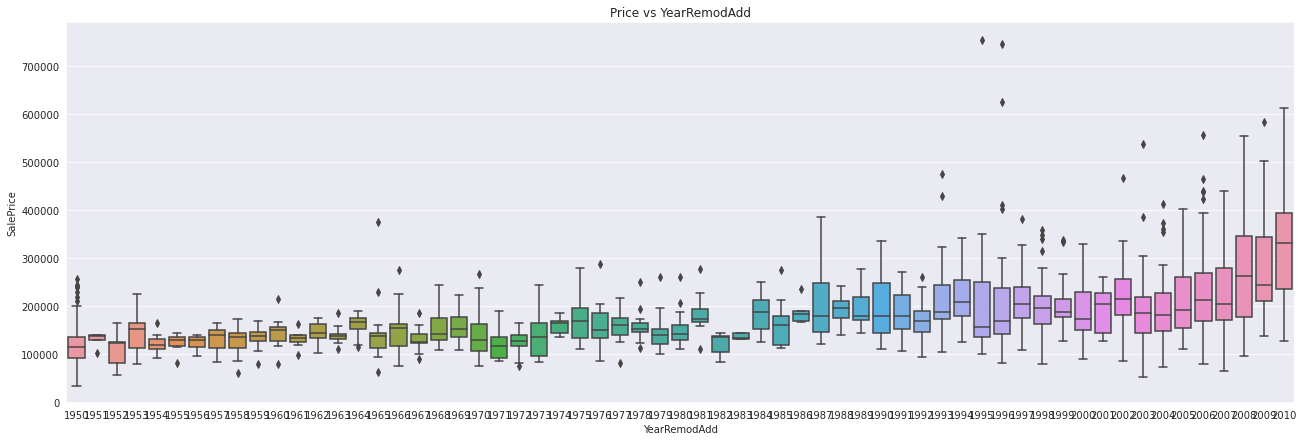

In [18]:
fig, ax = plt.subplots(1,1, figsize=(22,7))
sns.boxplot(x="YearRemodAdd", y="SalePrice", data=dataset_train, ax=ax)
ax.set_title('Price vs YearRemodAdd');

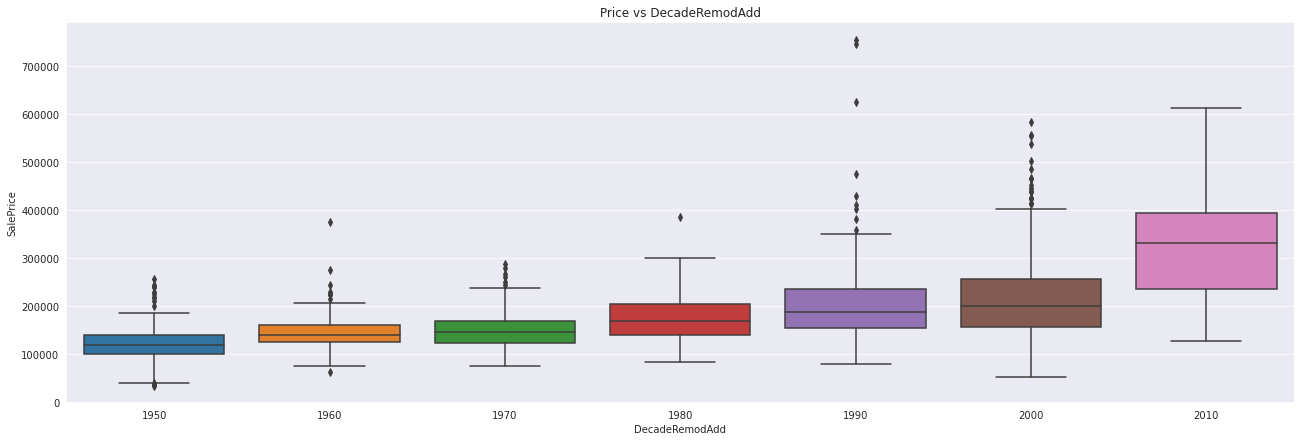

In [19]:
dataset_train['DecadeRemodAdd'] = dataset_train['YearRemodAdd']/10
dataset_train['DecadeRemodAdd'] = dataset_train['DecadeRemodAdd'].astype(int)*10
#dataset_train[['YearBuilt', 'DecadeBuilt']]

fig, ax = plt.subplots(1,1, figsize=(22,7))
sns.boxplot(x="DecadeRemodAdd", y="SalePrice", data=dataset_train, ax=ax)
ax.set_title('Price vs DecadeRemodAdd');

#### Things we can learn from the previous analysis
- The price of houses that were remodeled very recently (2010) is also a bit higher than the rest.
- There seem to be a small increase of the price the more recent the remodelation was done


### Let's see what we can learn from the number of room

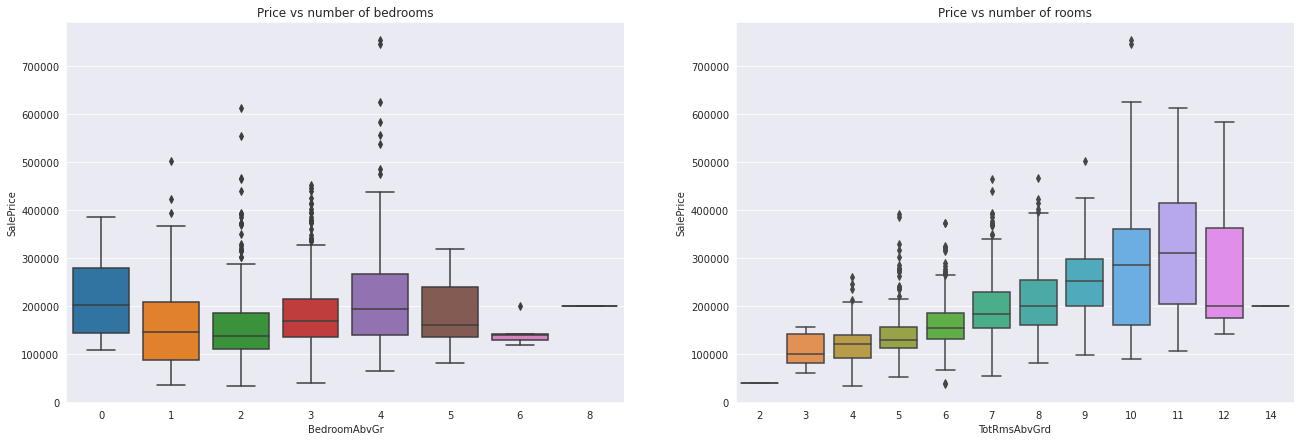

In [20]:
fig, ax = plt.subplots(1,2, figsize=(22,7))
sns.boxplot(x="BedroomAbvGr", y="SalePrice", data=dataset_train, ax=ax[0])
ax[0].set_title('Price vs number of bedrooms');
sns.boxplot(x="TotRmsAbvGrd", y="SalePrice", data=dataset_train, ax=ax[1])
ax[1].set_title('Price vs number of rooms');

#### What can we learn from the previous analysis
- The number of rooms is correlated to the price, which iwas to be expected
- The number of bedroom presents something interesting.
    - A house with 0 rooms aboe ground has a higher average price than houses with 1, 2 or 3 bedrooms above ground
    - We need to dig a bit more into the houses with 0 bedroom.
        - 1st idea, the number of rooms was badly indicated and we need to estimate it based on other features
        - 2nd idea, the rooms are actually in the basement.

### Let's dig a bit more in the houses with 0 bedroom above ground

In [21]:
df_0bd = dataset_train.loc[dataset_train['BedroomAbvGr'] == 0]
df_0bd[['YearBuilt', 'BldgType', 'BsmtFinType1', 'BsmtFinType2', 'TotalBsmtSF', 'GrLivArea', 'TotRmsAbvGrd', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'KitchenAbvGr', 'SalePrice']].head(20)

,YearBuilt,BldgType,BsmtFinType1,BsmtFinType2,TotalBsmtSF,GrLivArea,TotRmsAbvGrd,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,KitchenAbvGr,SalePrice
53,1981,1Fam,GLQ,Unf,1842,1842,5,2,0,0,1,1,385000
189,2001,TwnhsE,GLQ,Unf,1593,1593,5,1,0,1,1,1,286000
634,1980,Duplex,GLQ,Unf,1056,1056,4,2,0,0,0,2,144000
1163,1969,Duplex,GLQ,Unf,1198,1258,6,2,0,0,2,2,108959
1213,1965,1Fam,GLQ,Unf,648,960,3,1,1,0,0,1,145000
1270,1979,1Fam,GLQ,Unf,1332,1524,4,2,0,0,1,1,260000


In [22]:
df_0bd = dataset_test.loc[dataset_train['BedroomAbvGr'] == 0]
df_0bd[['YearBuilt', 'BldgType', 'BsmtFinType1', 'BsmtFinType2', 'TotalBsmtSF', 'GrLivArea', 'TotRmsAbvGrd', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'KitchenAbvGr']].head(20)


,YearBuilt,BldgType,BsmtFinType1,BsmtFinType2,TotalBsmtSF,GrLivArea,TotRmsAbvGrd,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,KitchenAbvGr
53,1962,Duplex,BLQ,Unf,1728.0,1728,10,2.0,0.0,2,0,2
189,1970,1Fam,ALQ,Unf,864.0,864,5,1.0,0.0,1,0,1
634,1940,2fmCon,BLQ,Unf,884.0,1436,8,0.0,0.0,2,0,2
1163,2005,1Fam,GLQ,Unf,1700.0,2212,9,1.0,0.0,2,1,1
1213,2004,TwnhsE,GLQ,Unf,1365.0,1548,7,1.0,0.0,2,0,1
1270,1934,1Fam,BLQ,Unf,816.0,816,4,1.0,0.0,1,0,1


Actually there is only a few houses without bedrooms above ground, but some have a very high number of rooms. <br>
There is probably a way of estimating the number of bedrooms

### Let's check if the conditions of the sales and the time of the sale have an impact on the price

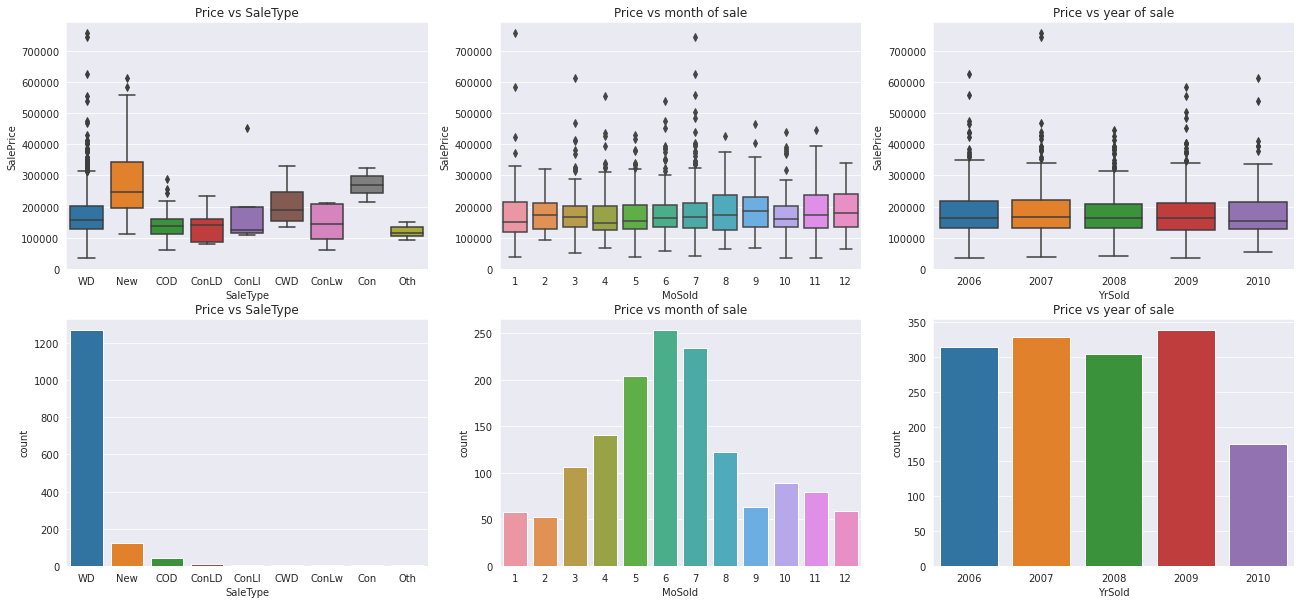

In [23]:
fig, ax = plt.subplots(2,3, figsize=(22,10))
sns.boxplot(x="SaleType", y="SalePrice", data=dataset_train, ax=ax[0][0])
ax[0][0].set_title('Price vs SaleType');
sns.boxplot(x="MoSold", y="SalePrice", data=dataset_train, ax=ax[0][1])
ax[0][1].set_title('Price vs month of sale');
sns.boxplot(x="YrSold", y="SalePrice", data=dataset_train, ax=ax[0][2])
ax[0][2].set_title('Price vs year of sale');
sns.countplot(x="SaleType", data=dataset_train, ax=ax[1][0])
ax[1][0].set_title('Price vs SaleType');
sns.countplot(x="MoSold", data=dataset_train, ax=ax[1][1])
ax[1][1].set_title('Price vs month of sale');
sns.countplot(x="YrSold", data=dataset_train, ax=ax[1][2])
ax[1][2].set_title('Price vs year of sale');

The year and month of sale does not seem to have an impact on the price. <br>
The sale type seems to have an impact but outside of new houses I don't think it is usefull to consider other types of sale because of the population size which is very small.

# 4. Data cleaning and feature selection

Let's start by creating some new columns as we stated in the column analysis.

### Columns we will transform
- OverallQual & OverallCond, we can probably aggregate these columns together
- YearBuilt & YearRemodAdd
- Check if all these columns ExterQual, ExterCond, BsmtCond, BsmtFinType1, BsmtFinType2, HeatingQC, KitchenQual, GarageQual and GarageCond give us a good aproximation of overall quality and overall condition or if there was some errors during the calculation
- TotalSF = TotalBsmtSF + 1stFlrSF + 2ndFlrSF
- TotalBath = FullBath + HalfBath + BsmtFullBath + BsmtHalfBath
- TotalPorch = WoodDeckSF + openPorchSF + EnclosedPorch + 3SsnPorch + ScreenPorch

Let's start with a study of the quality and condition of the house

In [24]:
dataset_train[['OverallQual', 'ExterQual', 'BsmtQual', 'HeatingQC', 'FireplaceQu', 'GarageQual', 'PoolQC']]

,OverallQual,ExterQual,BsmtQual,HeatingQC,FireplaceQu,GarageQual,PoolQC
0,7,Gd,Gd,Ex,NaN,TA,NaN
1,6,TA,Gd,Ex,TA,TA,NaN
2,7,Gd,Gd,Ex,TA,TA,NaN
3,7,TA,TA,Gd,Gd,TA,NaN
4,8,Gd,Gd,Ex,TA,TA,NaN
...,...,...,...,...,...,...,...
1455,6,TA,Gd,Ex,TA,TA,NaN
1456,6,TA,Gd,TA,TA,TA,NaN
1457,7,Ex,TA,Ex,Gd,TA,NaN
1458,5,TA,TA,Gd,NaN,TA,NaN


In [25]:
dataset_train[['OverallCond', 'ExterCond', 'BsmtCond', 'HeatingQC', 'GarageCond']]

,OverallCond,ExterCond,BsmtCond,HeatingQC,GarageCond
0,5,TA,TA,Ex,TA
1,8,TA,TA,Ex,TA
2,5,TA,TA,Ex,TA
3,5,TA,Gd,Gd,TA
4,5,TA,TA,Ex,TA
...,...,...,...,...,...
1455,5,TA,TA,Ex,TA
1456,6,TA,TA,TA,TA
1457,9,Gd,Gd,Ex,TA
1458,6,TA,TA,Gd,TA


There is differences of OverallCond between houses with the same score for ExterCond, BsmtCond, HeatingQC, GarageCond.
We could recalculate a new score for the overall condition.

In [26]:
for col in ['ExterCond', 'BsmtCond', 'HeatingQC', 'GarageCond']:
    dataset_train[col] = dataset_train[col].map({'Ex':9,'Gd':7,'TA':5,'Fa':3,'NA':np.nan}, na_action='ignore')
 
dataset_train['OverallCond_calculated'] = dataset_train[['ExterCond', 'BsmtCond', 'HeatingQC', 'GarageCond']].mean(axis=1)
dataset_train['OverallCond'] = dataset_train['OverallCond'].astype(float)
df = dataset_train.loc[abs(dataset_train['OverallCond'] - dataset_train['OverallCond_calculated']) > 1]
dataset_train['OverallCond_calculated'] = dataset_train['OverallCond_calculated'].astype(int)
dataset_train['OverallCond_calculated_2'] = dataset_train[['OverallCond_calculated', 'OverallCond']].mean(axis=1).astype(int)

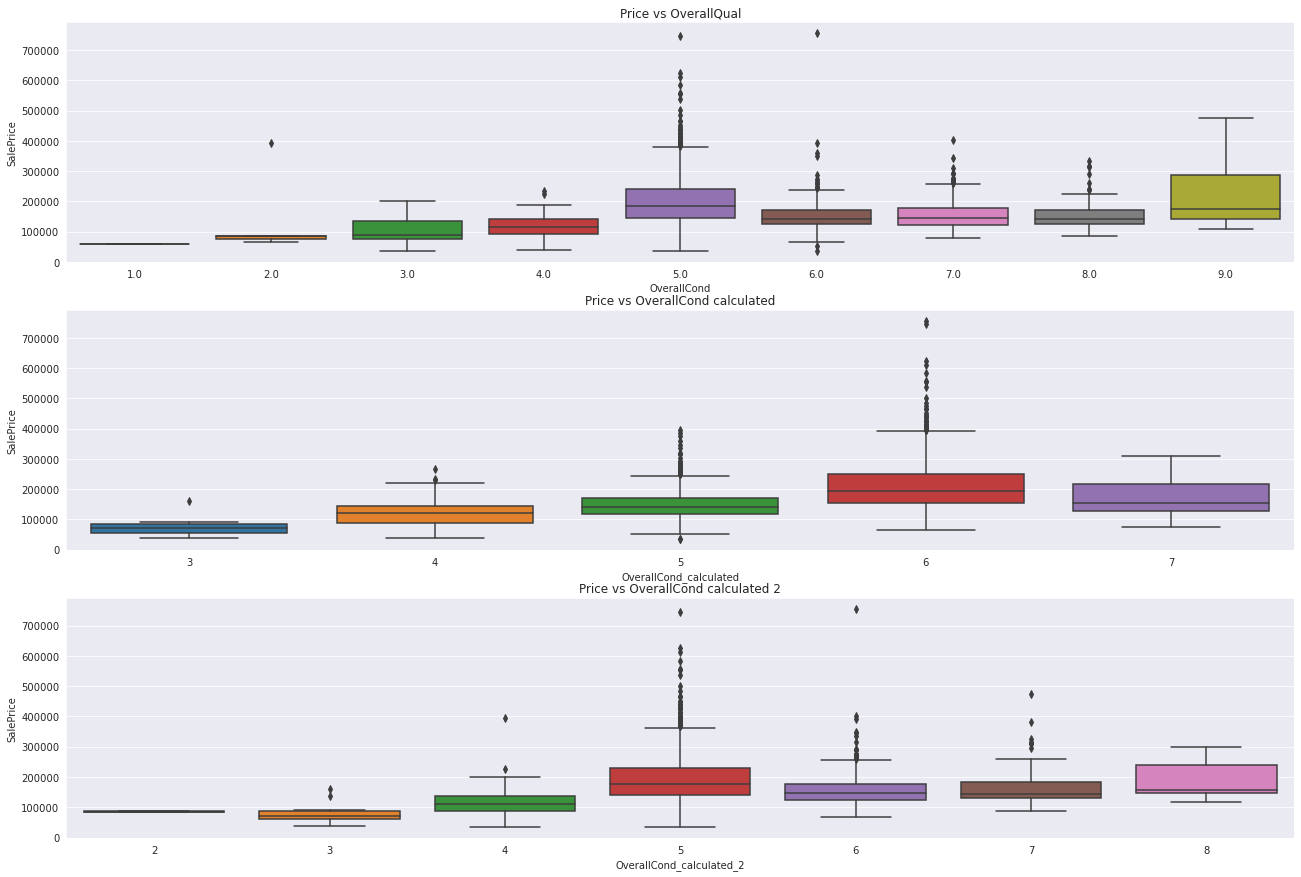

In [27]:
fig, ax = plt.subplots(3,1, figsize=(22,15))
sns.boxplot(x="OverallCond", y="SalePrice", data=dataset_train, ax=ax[0])
ax[0].set_title('Price vs OverallQual');
sns.boxplot(x="OverallCond_calculated", y="SalePrice", data=dataset_train, ax=ax[1])
ax[1].set_title('Price vs OverallCond calculated');
sns.boxplot(x="OverallCond_calculated_2", y="SalePrice", data=dataset_train, ax=ax[2])
ax[2].set_title('Price vs OverallCond calculated 2');

It seems that by averaging the overall condition score and our calculated condition score and binning the result into two categories: <br>
good condition (>=5) and  average condition (<5) we could get a better feature.

Let's now check if the calculus of square feet is proprerly made.

In [31]:
#TotalSF = TotalBsmtSF + 1stFlrSF + 2ndFlrSF + BsmtUnfSF + LowQualFinSF
dataset_train['TotalSF_calculated'] = dataset_train[['TotalBsmtSF', '1stFlrSF', '2ndFlrSF']].sum(axis=1)
dataset_train[['TotalSF', 'TotalSF_calculated', 'TotalBsmtSF','1stFlrSF','2ndFlrSF', 'BsmtUnfSF','LowQualFinSF']]

,TotalSF,TotalSF_calculated,TotalBsmtSF,1stFlrSF,2ndFlrSF,BsmtUnfSF,LowQualFinSF
0,2566,2566,856,856,854,150,0
1,2524,2524,1262,1262,0,284,0
2,2706,2706,920,920,866,434,0
3,2473,2473,756,961,756,540,0
4,3343,3343,1145,1145,1053,490,0
...,...,...,...,...,...,...,...
1455,2600,2600,953,953,694,953,0
1456,3615,3615,1542,2073,0,589,0
1457,3492,3492,1152,1188,1152,877,0
1458,2156,2156,1078,1078,0,0,0


In [33]:
len(dataset_train.loc[abs(dataset_train['TotalSF'] - dataset_train['TotalSF_calculated']) > 1])

0

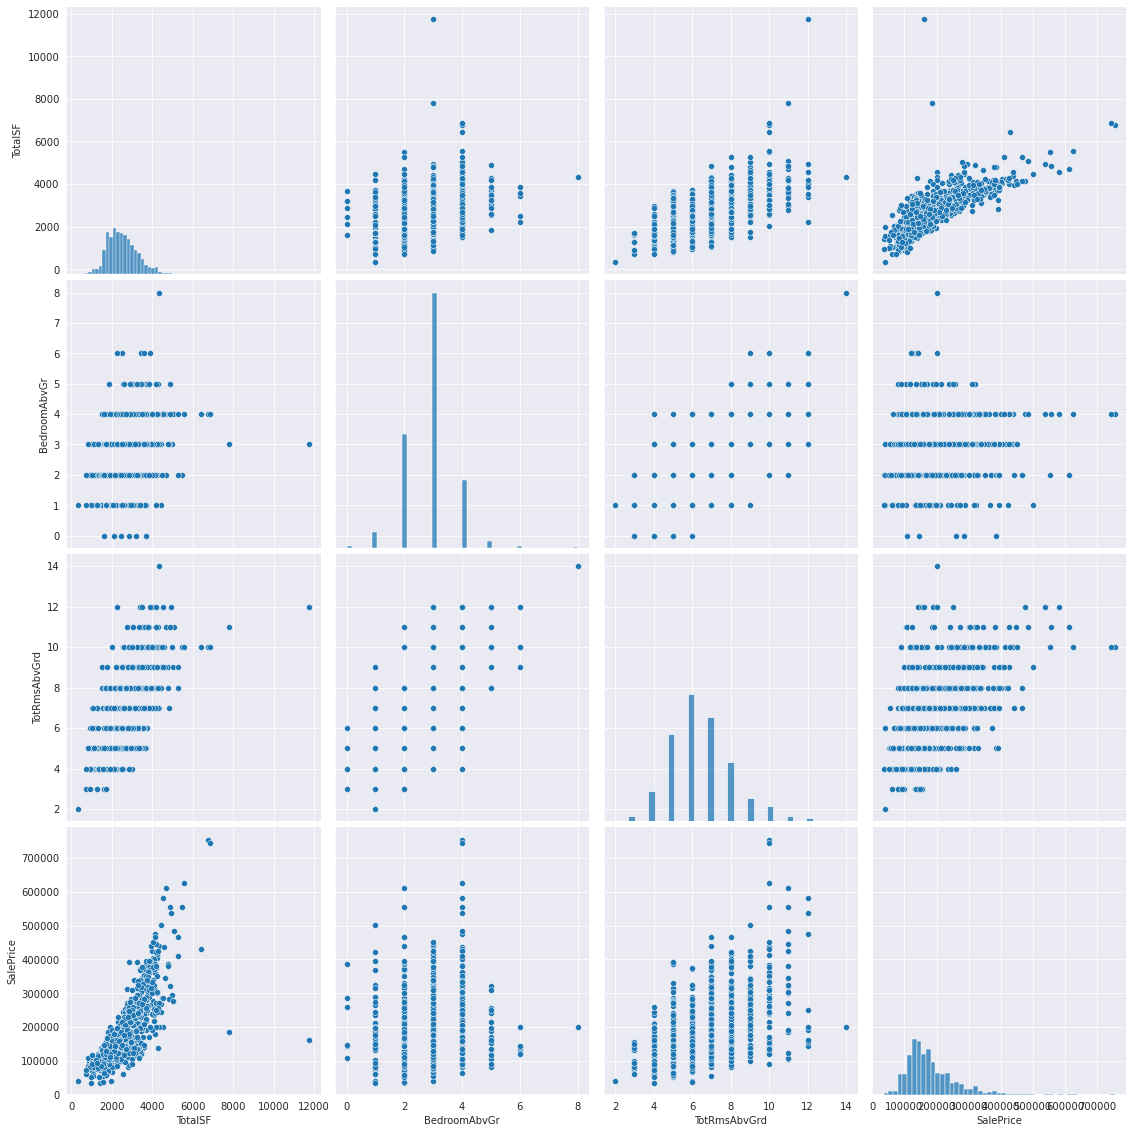

In [53]:
sns.pairplot(data=dataset_train[['TotalSF', 'BedroomAbvGr', 'TotRmsAbvGrd', 'SalePrice']], height=4)

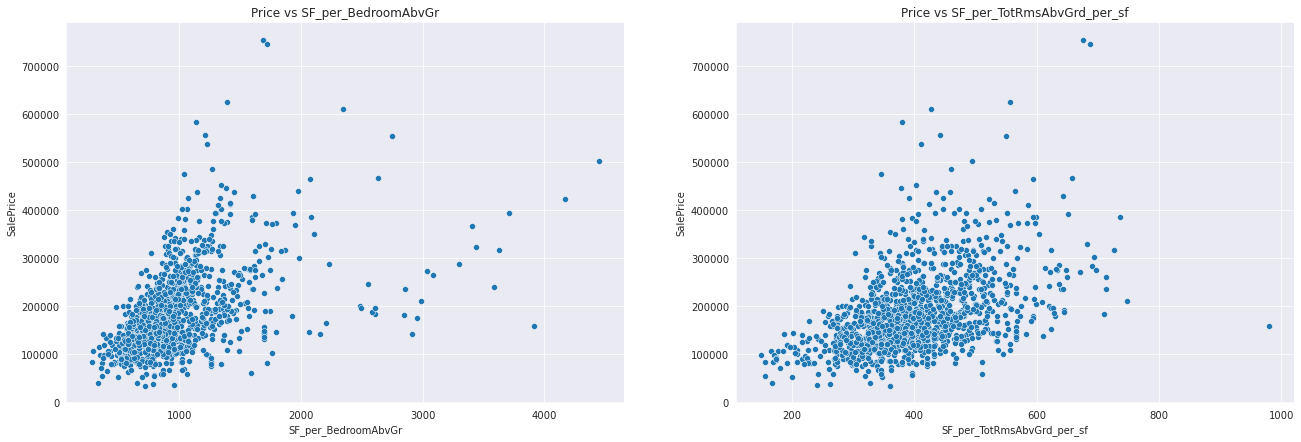

In [51]:
dataset_train['SF_per_BedroomAbvGr'] = dataset_train['TotalSF']/dataset_train['BedroomAbvGr']
dataset_train['SF_per_TotRmsAbvGrd_per_sf'] = dataset_train['TotalSF']/dataset_train['TotRmsAbvGrd']
fig, ax = plt.subplots(1,2, figsize=(22,7))
sns.scatterplot(x="SF_per_BedroomAbvGr", y="SalePrice", data=dataset_train, ax=ax[0])
ax[0].set_title('Price vs SF_per_BedroomAbvGr');
sns.scatterplot(x="SF_per_TotRmsAbvGrd_per_sf", y="SalePrice", data=dataset_train, ax=ax[1])
ax[1].set_title('Price vs SF_per_TotRmsAbvGrd_per_sf');